In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = False

run2_input = False

omtf_input = True

model_name = 'model'

epochs = 300

batch_size = 256*4*2

if omtf_input:
  from nn_encode_omtf import nlayers, nvariables
  from nn_data_omtf import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  model_name = 'model_omtf'

In [3]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon_omtf, reg_pt_scale=reg_pt_scale, test_size=0.311)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba_omtf.22.npz ...
[INFO    ] Loaded the variables with shape (1919270, 179)
[INFO    ] Loaded the parameters with shape (1919270, 5)
[INFO    ] Loaded the encoded variables with shape (1919270, 30)
[INFO    ] Loaded the encoded parameters with shape (1919270,)
[INFO    ] Loaded # of training and testing events: (1322377, 596893)


In [4]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup_omtf, reg_pt_scale=reg_pt_scale, test_job=139)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from ../test7/histos_tbd_omtf.22.npz ...
[INFO    ] Loaded the variables with shape (278657, 179)
[INFO    ] Loaded the auxiliary PU info with shape (278657, 4)
[INFO    ] Loaded the encoded variables with shape (278657, 30)
[INFO    ] Loaded the encoded auxiliary PU info with shape (278657, 4)
[INFO    ] Loaded # of training and testing events: (223212, 55445)


### Training

In [5]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator
# BN is applied right after the input layers

if do_training:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, 
                                                   discr_pt_cut=discr_pt_cut, tile=6)
  else:
    raise Exception('add_noise must be set to True')
  
  model = create_model_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, 
                           l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                           nodes1=30, nodes2=25, nodes3=20)
  logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
  
  # Start training
  history = train_model(model, x_train_new, y_train_new,
                        model_name=model_name, epochs=epochs, batch_size=batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [6]:
# Validation

if do_training:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [7]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [8]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name=model_name, weights_name=model_name+'_weights')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//4

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] # of entries: 149223, mean: -0.000914609525353, std: 0.0317814797163
[INFO    ] gaus fit (a, mu, sig): [ 2.64993121e+04 -2.64527335e-04  1.16732020e-02]


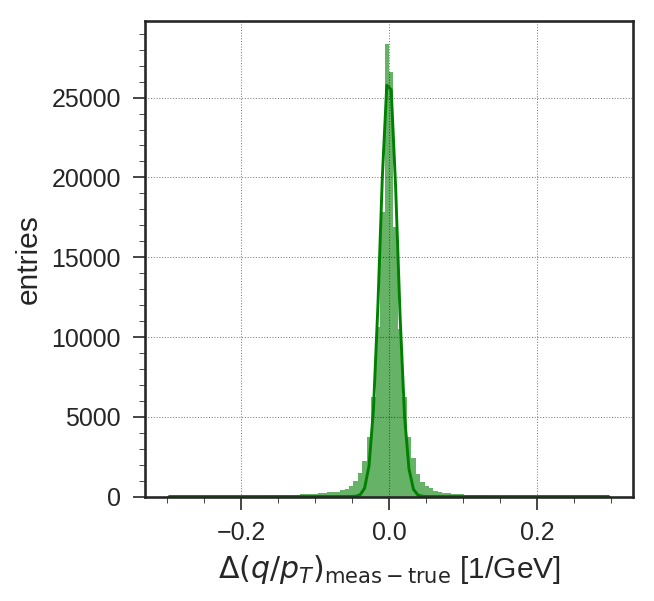

In [9]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 149223, mean: 0.737149238586, std: 0.2717038095
[INFO    ] gaus fit (a, mu, sig): [ 1.82259807e+04 -2.00922060e-03  1.10389536e-01]


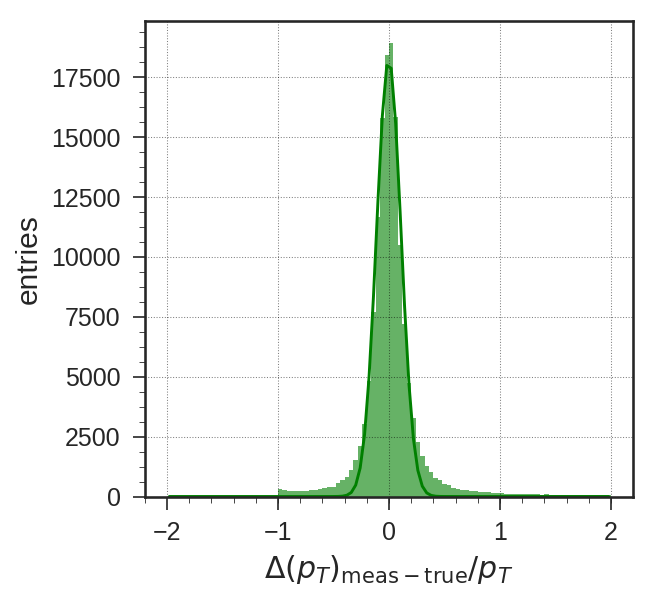

In [10]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


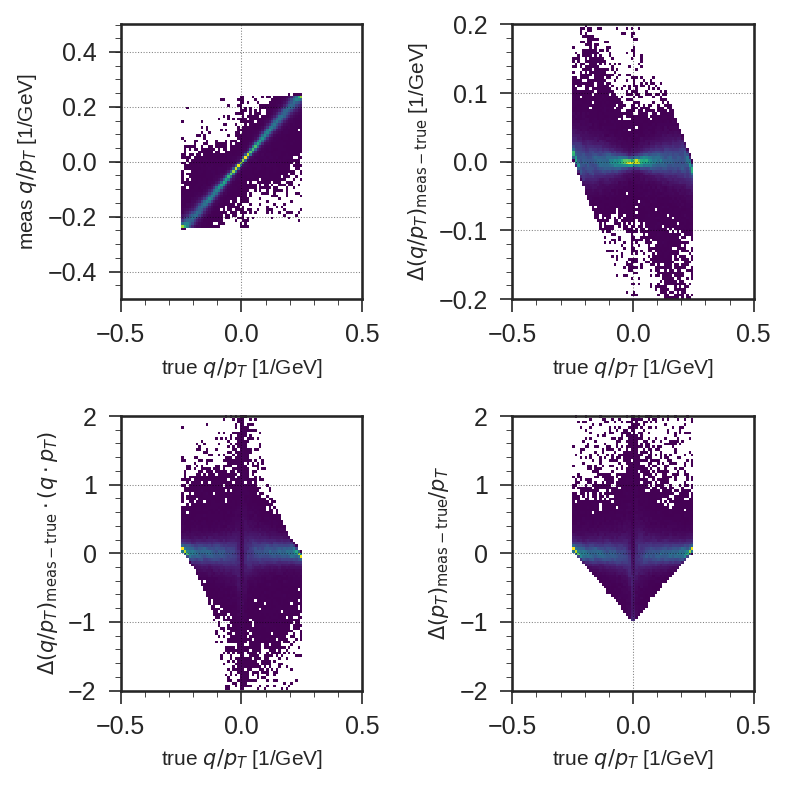

In [11]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [12]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.3)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [ 2.77765038e+02 -3.15187982e-02  1.48741128e-01]


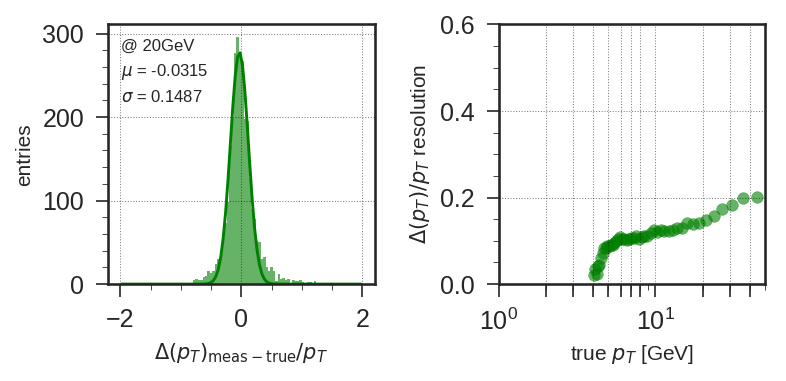

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,0.6+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

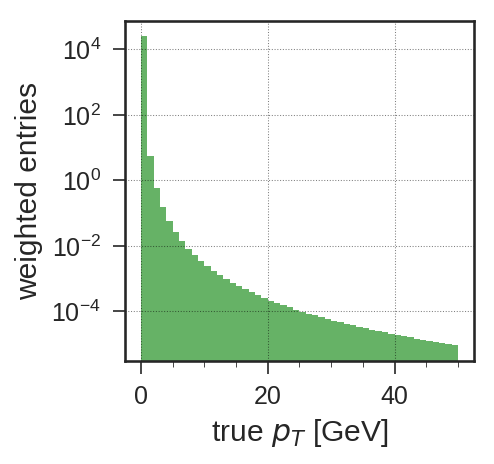

In [14]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [15]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 15.9913978577 rate 272.504272461
[INFO    ] 22 GeV threshold 16.9820270538 rate 248.101531982


### Classification Results

In [16]:
# Prepare y_test_true, y_test_meas (again)
y_test_true = [y_test[0][:nentries_test].copy(), y_test[1][:nentries_test].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=4096)
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

In [17]:
def get_modes_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)

  mode_me0 = np.int32(0)
  if valid[11]: # ME0
    mode_me0 |= (1 << 2)
  if valid[0]:  # ME1/1
    mode_me0 |= (1 << 1)
  if np.any((valid[2], valid[3], valid[4])):  # ME2, ME3, ME4
    mode_me0 |= (1 << 0)
  
  mode_omtf = np.int32(0)
  if valid[12]: # MB1
    mode_omtf |= (1 << 3)
  if valid[13]: # MB2
    mode_omtf |= (1 << 2)
  if valid[14]: # MB3
    mode_omtf |= (1 << 1)
  if valid[1]:  # ME1/3
    mode_omtf |= (1 << 1)
  if np.any((valid[2], valid[3], valid[4])):  # ME2, ME3, ME4
    mode_omtf |= (1 << 0)
  return (mode, mode_me0, mode_omtf)

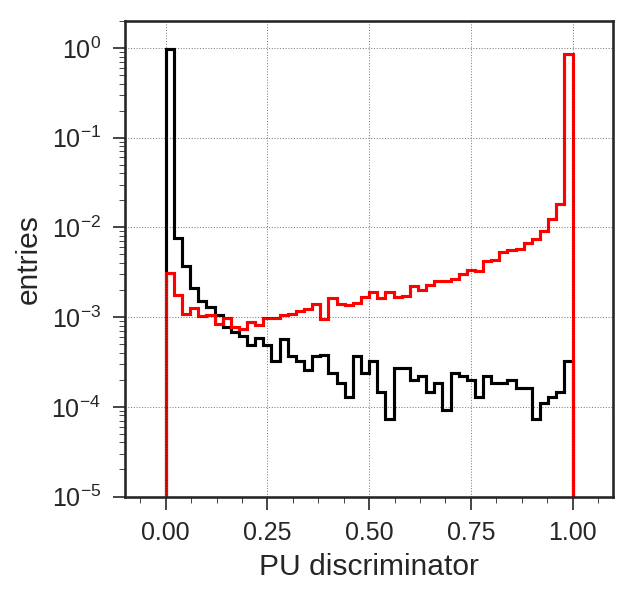

In [18]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))
tt = np.concatenate((x_mask_test[:nentries_test][y_test_sel], pu_x_mask_test[pu_y_test_sel]))

def roc_singlemu(x_mask):
  (mode, mode_me0, mode_omtf) = get_modes_from_x_mask(x_mask)
  mode_ok = (mode in (11,13,14,15)) or (mode_me0 == 7) or (mode_omtf not in (0,1,2,4,8))
  return mode_ok

tt = np.apply_along_axis(roc_singlemu, 1, tt)  # require SingleMu quality
xx = xx[:, np.newaxis]
xx = xx[tt]
yy = yy[tt]
zz = zz[tt]

[INFO    ] auc: 0.998266473892
[INFO    ] thr: [0.9295, 0.8633, 0.7585, 0.6091, 0.5501, 0.4978, 0.4247, 0.3403, 0.0196]
[INFO    ] tpr: [0.9009, 0.9251, 0.9502, 0.9702, 0.9758, 0.9802, 0.9853, 0.9901, 0.9990]
[INFO    ] fpr: [0.0028, 0.0051, 0.0104, 0.0177, 0.0214, 0.0241, 0.0285, 0.0335, 0.0874]


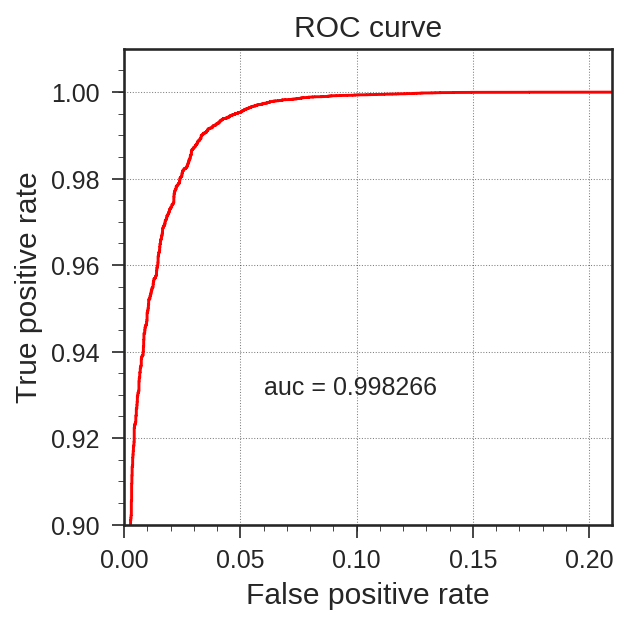

In [20]:
# Plot ROC (pT > 8 GeV)
zzz = np.abs(1.0/zz) > discr_pt_cut
xxx = xx[zzz]
yyy = yy[zzz]

fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.21)
plt.ylim(0.9,1.01)
plt.show()

[INFO    ] auc: 0.999285879969
[INFO    ] thr: [0.9820, 0.9619, 0.8978, 0.8545, 0.8296, 0.7421, 0.6967, 0.5827, 0.0246]
[INFO    ] tpr: [0.9041, 0.9274, 0.9604, 0.9708, 0.9750, 0.9828, 0.9856, 0.9902, 0.9990]
[INFO    ] fpr: [0.0007, 0.0019, 0.0040, 0.0059, 0.0068, 0.0087, 0.0110, 0.0141, 0.0576]


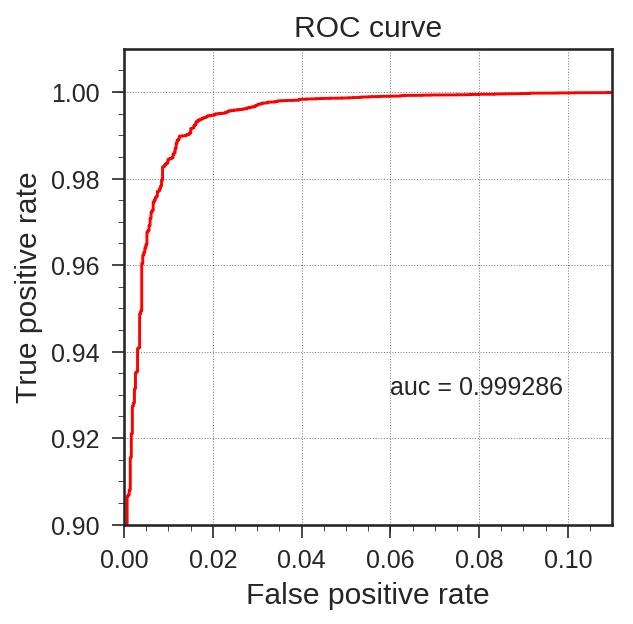

In [21]:
# Plot ROC (pT > 14 GeV)
zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]

fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.11)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

In [22]:
# Build track producer

from six.moves import range, zip, map, filter

pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - np.abs(ipt - best_ipt)

nvariables = nvariables

discr_pt_cut = discr_pt_cut

def get_theta_median_from_x(x):
  assert(x.shape[0] == nvariables)
  theta_median = x[-1] # last variable
  return theta_median.astype(np.int32)

def get_zone_from_x(x):
  assert(x.shape[0] == nvariables)
  zone = x[-2] # second last variable
  return zone.astype(np.int32)

def get_straightness_from_x(x):
  assert(x.shape[0] == nvariables)
  straightness = x[-3] # third last variable
  return straightness.astype(np.int32)

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

class TrackProducer(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8005,  1.5194,  1.5708,  1.8247,  2.1989,  2.6489,  3.1625,  3.7251,
                  4.3240,  4.9595,  5.6337,  6.3424,  7.0590,  7.7485,  8.4050,  9.0398,
                  9.6598, 10.2800, 10.9236, 11.6060, 12.3216, 13.0521, 13.7887, 14.5427,
                 15.2964, 16.0232, 16.7303, 17.4535, 18.2066, 19.0044, 19.8400, 20.6934,
                 21.5215, 22.3143, 23.1066, 23.8221, 24.4586, 25.1335, 25.9083, 26.7333,
                 27.5310, 28.2623, 28.9778, 29.7226, 30.5507, 31.4670, 32.4541, 33.5263,
                 34.5659, 35.5155, 36.4457, 37.4019, 38.3762, 39.3604, 40.3595, 41.3763,
                 42.3333, 43.2434, 44.2686, 45.5962, 47.0878, 48.3783, 49.4891, 50.5445,
                 51.4431, 52.2846, 53.1180, 53.9492, 54.7793, 55.6090, 56.4384, 57.2676,
                 58.0967, 58.9257, 59.7547, 60.5836, 61.4125, 62.2413, 63.0702, 63.8990,
                 64.7278, 65.5566, 66.3854, 67.2142, 68.0430, 68.8718, 69.7006, 70.5293,
                 71.3581, 72.1869, 73.0157, 73.8444, 74.6732, 75.5020, 76.3307, 77.1595,
                 77.9882, 78.8170, 79.6458, 80.4745, 81.3033, 82.1321, 82.9608, 83.7896,
                 84.6183, 85.4471, 86.2759, 87.1046, 87.9334, 88.7621, 89.5909, 90.4197,
                 91.2484, 92.0772, 92.9059, 93.7347, 94.5635, 95.3922, 96.2210, 97.0497]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, x, y_meas):
    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return binx.astype(np.int32)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if binx == self.s_nbins-1:  # check boundary
      binx -= 1

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, strg, ndof, modes, theta_median, y_meas, y_discr, discr_pt_cut):
    #ipt1 = strg
    #ipt2 = find_pt_bin(y_meas)
    #quality1 = find_emtf_road_quality(ipt1)
    #quality2 = find_emtf_road_quality(ipt2)
    
    (mode, mode_me0, mode_omtf) = modes
    mode_ok = (mode in (11,13,14,15)) or (mode_me0 == 7) or (mode_omtf not in (0,1,2,4,8))

    if mode_ok:
      if np.abs(1.0/y_meas) > discr_pt_cut_high:
        trigger = (y_discr > 0.9136) # 98.0% coverage
      elif np.abs(1.0/y_meas) > discr_pt_cut:
        trigger = (y_discr > 0.7415) # 98.0% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger

  def run(self, slim_roads, variables, predictions, other_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(other_vars))

    tracks = []

    for myroad, myvars, mypreds, myother in zip(slim_roads, variables, predictions, other_vars):
      assert(len(myvars.shape) == 1)
      x = myvars
      x_mask = myother
      y_meas = np.asscalar(mypreds[...,0])
      y_discr = np.asscalar(mypreds[...,1])

      theta_median = get_theta_median_from_x(x)
      zone = get_zone_from_x(x)
      strg = get_straightness_from_x(x)
      ndof = get_ndof_from_x_mask(x_mask)
      modes = get_modes_from_x_mask(x_mask)

      passed = self.pass_trigger(strg, ndof, modes, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
      xml_pt = np.abs(1.0/y_meas)
      pt = self.get_trigger_pt(x, y_meas)

      if passed:
        trk_q = np.sign(y_meas)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = myroad.theta_median
        trk = Track(myroad.id, myroad.hits, mode, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_discr)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer()

In [23]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, y_meas, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, y_test_meas[0], y_test_meas[1], y_test_true[0])):
  theta_median = get_theta_median_from_x(x)
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  modes = get_modes_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, modes, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_discr), float(pt_true), float(xml_pt), float(pt), passed
  
eff_data = np.asarray(eff_data)

0 2 0.996606469154 38.1110566244 51.9273757935 84.4979326401 [ True]
1 6 0.997904539108 6.90737852468 7.37584066391 8.8821673069 [ True]
2 5 1.0 30.9131861873 42.122253418 68.2456472656 [ True]
3 4 0.99984061718 6.09184969153 6.40717411041 7.62049309826 [ True]
4 4 0.999999880791 23.4241532903 8.59817314148 10.4063684677 [ True]
5 7 0.997694790363 5.61701770064 6.05123615265 7.1296546545 [ True]
6 5 0.999970555305 10.0320690809 9.74247837067 11.9530350441 [ True]
7 5 0.999997735023 14.4043357548 16.4784526825 22.2801345734 [ True]
8 4 0.999943852425 4.47649914898 5.17271184921 5.87850177507 [ True]
9 8 0.999999403954 15.8305416916 15.0412082672 19.9103342705 [ True]
10 5 0.9996560812 4.04330135149 4.81876993179 5.38932937603 [ True]
11 4 0.997271478176 5.22700786393 5.61560630798 6.5080869606 [ True]
12 4 0.999628543854 5.64720439296 5.6726641655 6.58986228199 [ True]
13 5 0.999790132046 5.35185591166 5.7160077095 6.65198224926 [ True]
14 5 0.999993920326 7.39243814911 7.83694839478 9.

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


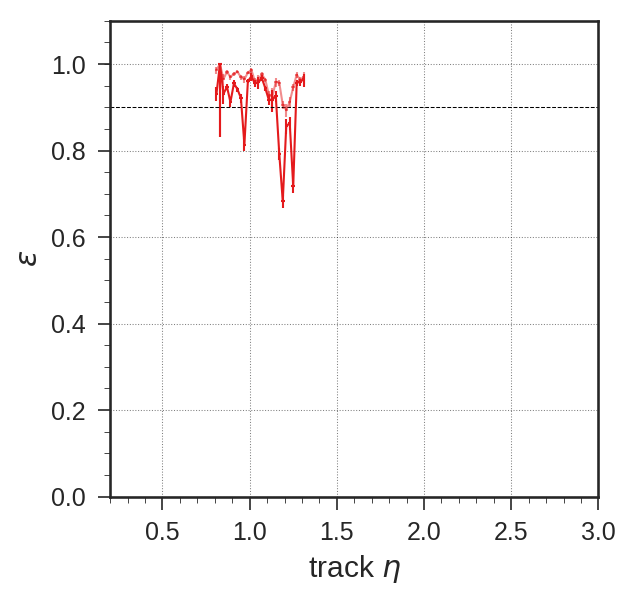

In [24]:
# Efficiency vs eta
plt.figure()

color = my_palette[1]
nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is pt_true
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))  
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
#print pt, ydata

plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist

plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, alpha=0.5, marker=',', capsize=0, lw=1)
  
plt.plot([xlow-0.5,xup+0.5], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(xlow-0.5,xup+0.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


10.0 [       nan        nan        nan        nan        nan        nan
 0.00857068 0.01540646 0.0362956  0.1540834  0.57488333 0.84257759
 0.88863873 0.87919622 0.88408355 0.89403483 0.91476479 0.91334769
 0.92325263 0.92674986 0.92714517 0.92916667 0.93352741 0.92867756
 0.93216958 0.9314578 ]
20.0 [       nan        nan        nan        nan        nan        nan
 0.00318788 0.00340788 0.00383536 0.00444115 0.0106067  0.0269226
 0.12435054 0.36903073 0.67931745 0.81622823 0.8691197  0.87782562
 0.90497944 0.90992946 0.91203454 0.91944444 0.92479379 0.92570579
 0.91970075 0.92276215]
30.0 [       nan        nan        nan        nan        nan        nan
 0.00182911 0.00234292 0.00224509 0.00222058 0.00466695 0.00760314
 0.01368202 0.02671395 0.06031186 0.16487588 0.34653004 0.53498385
 0.74645957 0.85349973 0.88289261 0.90787037 0.91606016 0.9157999
 0.91620948 0.91815857]
40.0 [       nan        nan        nan        nan        nan        nan
 0.00167233 0.00191693 0.00159027 0.001

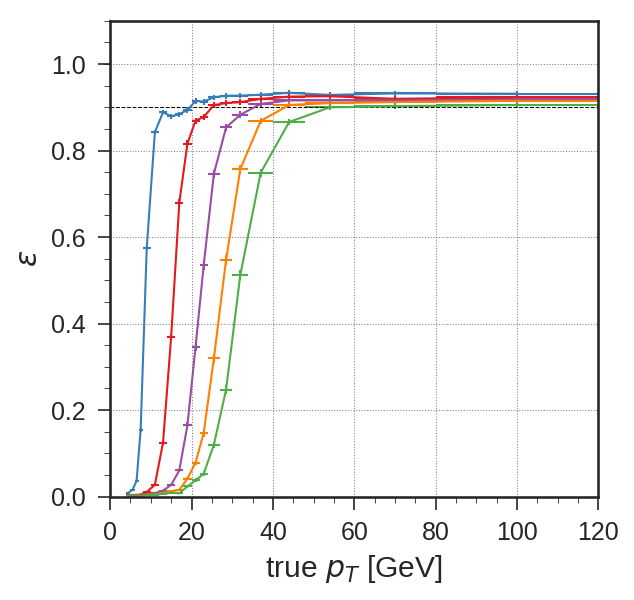

In [25]:
# Efficiency vs pT
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50., 60.)

plt.figure()

gen_passed = (1.2 <= eff_data_eta) & (eff_data_eta <= 2.4)
if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.2)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is pt_true

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is pt_true
  eff_hist = np.true_divide(num_hist, denom_hist)
  
  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  print pt, ydata
  
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [26]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((5,nbinsx), dtype=np.float32)

for j in xrange(5):  # j = zone0-1, zone2-4, zone5, zone6, all zones
  if j == 0:
    eff_data_tmp = np.logical_or(eff_data[:,0]==0, eff_data[:,0]==1)
  elif j == 1:
    eff_data_tmp = np.logical_or(eff_data[:,0]==2, eff_data[:,0]==3, eff_data[:,0]==4)
  elif j == 2:
    eff_data_tmp = (eff_data[:,0]==5)
  elif j == 3:
    eff_data_tmp = (eff_data[:,0]==6)
  elif j == 4:
    eff_data_tmp = (eff_data[:,0]>=0)
  
  xx = eff_data[:,1][eff_data_tmp]  # pt_true
  yy = eff_data[:,2][eff_data_tmp]  # xml_pt
  zz = eff_data[:,4][eff_data_tmp]  # discr_passed
  
  ind = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 4:  # ignore below 4 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90  
    coverage += 1.0 # inefficiency due to fiducial cuts
    #coverage += 1.5 # inefficiency due to fiducial cuts
    #pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue
    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    
    xxx[j,i] = pct
    
    # Debug
    if j == 3 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

14.0 12.5751879699
14.5 12.8420211704
15.0 12.7735690236
15.5 12.5
16.0 12.4011167985
16.5 12.5122189638
17.0 12.0711890637
17.5 11.4403292181
18.0 10.9489051095
18.5 10.3363159519
19.0 9.73624226636
19.5 9.26183844011
20.0 9.40450254176
20.5 8.90072270825
21.0 9.23317683881
21.5 9.2585006145
22.0 9.36698032506
22.5 9.44669365722
23.0 9.69581749049
23.5 9.23231309584
24.0 9.01554404145
24.5 8.2702020202
25.0 7.98826214542
25.5 7.94502179014
26.0 7.92661820699
26.5 7.99569738257
27.0 8.12826249068
27.5 8.11751063007
28.0 8.256141764
28.5 8.16411106506
29.0 8.22037603848
29.5 8.01993656547
30.0 7.85984848485


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

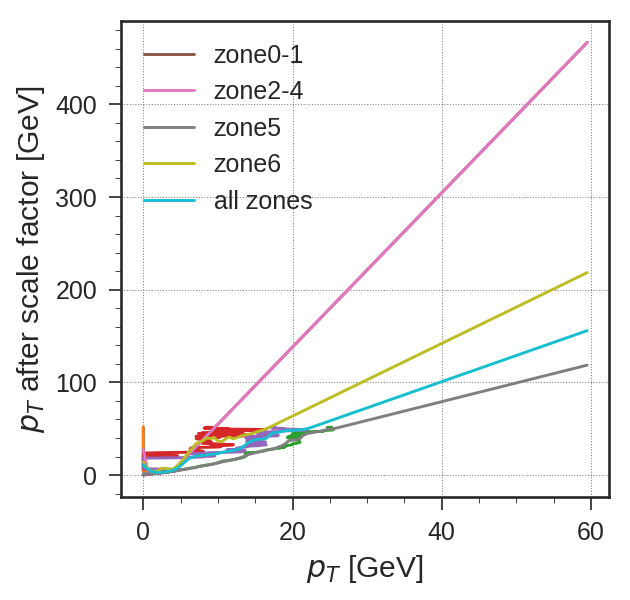

In [27]:
plt.figure()

xdata = (xedges[1:] + xedges[:-1])/2
plt.plot(xxx[0,:-16], xdata[:-16])
plt.plot(xxx[1,:-16], xdata[:-16])
plt.plot(xxx[2,:-16], xdata[:-16])
plt.plot(xxx[3,:-16], xdata[:-16])
plt.plot(xxx[4,:-16], xdata[:-16])
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

xdata = xedges[:-1]
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

line0, = plt.plot(xdata, ydata0)
line1, = plt.plot(xdata, ydata1)
line2, = plt.plot(xdata, ydata2)
line3, = plt.plot(xdata, ydata3)
line4, = plt.plot(xdata, ydata4)

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
#assert(monotonically_increasing(ydata4[4:]))  #FIXME

plt.legend((line0, line1, line2, line3, line4), ('zone0-1', 'zone2-4', 'zone5', 'zone6', 'all zones'), loc='upper left')
plt.show()

In [28]:
# Rates
rates_jobid_offset = 109
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, y_meas, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test)):
  theta_median = get_theta_median_from_x(x)
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  modes = get_modes_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, modes, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  trk_eta = theta_to_eta_lut[theta_median]
  trk_eta_ok = (1.2 <= trk_eta <= 2.4)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.2)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), ndof, pt, y_discr
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        nlayers_omtf = 9
        for lay in xrange(nlayers_omtf):
          tmp = np.arange(2) * nlayers_omtf + lay
          print "....", lay, x[tmp]

  31 1987  1.2715     nan 2 [81.9903582] [0.9684765]
  31 2627  3.0357     nan 2 [27.39724564] [0.94361085]
  50  285 17.3931     nan 3 [22.84646033] [0.98847944]
  50 2889  1.2398  8.5000 2 [21.99696104] [0.9439774]
  56 3082 13.2226     nan 2 [20.24996692] [0.92252463]
  60 1362 19.7964     nan 3 [24.60617516] [0.99986506]


[INFO    ] nevents: 258400/498400


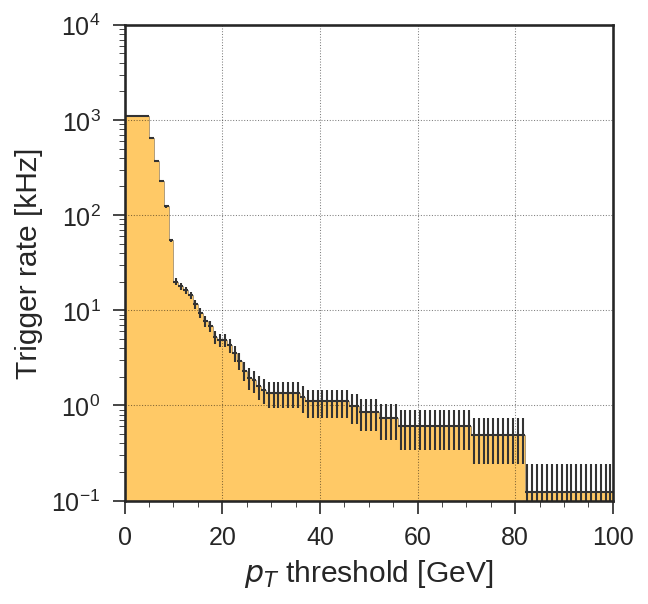

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 5.25498079509, 4.8883542344, 4.8883542344, 4.27730994672, 3.54405682534


[1.1024e+03, 1.1024e+03, 1.1024e+03, 1.1024e+03, 1.1024e+03, 6.4648e+02,
 3.6638e+02, 2.2658e+02, 1.2343e+02, 5.4139e+01, 2.0042e+01, 1.7965e+01,
 1.6132e+01, 1.4298e+01, 1.1610e+01, 9.4101e+00, 7.6992e+00, 6.8437e+00,
 5.2550e+00, 4.8884e+00, 4.8884e+00, 4.2773e+00, 3.5441e+00, 2.9330e+00,
 2.3220e+00, 1.9553e+00, 1.8331e+00, 1.5887e+00, 1.4665e+00, 1.3443e+00,
 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00,
 1.2221e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00,
 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 9.7767e-01, 9.7767e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 7.3325e-01, 7.3325e-01,
 7.3325e-01, 7.3325e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 4.8884e-01,
 4.8884e-01, 4.8884e-01, 4.8884e-01, 4.8884e-01, 4.8884e-01, 4.8884e-01,
 4.8884e-01, 4.8884e-01, 4.8884e-01, 4.8884e-01, 1.

In [29]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

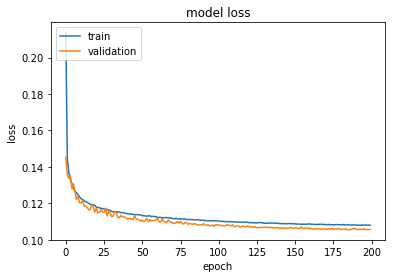

In [30]:
# Training history
# 2018-10-16

"""
[INFO    ] Done training. Time elapsed: 0:49:25.753825 sec
[INFO    ] Epoch 200/200 - loss: 0.10789669651 - regr_loss: 1.67813146207 - discr_loss: 0.0239901219336 - val_loss: 0.105607583236 - val_regr_loss: 1.63417662615 - val_discr_loss: 0.0238987506903
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAYwAAAEWCAYAAAB1xKBvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzt3Xl8nGW99/HPbyaTfWmapntLW+i+l1JAKIsgh7LvrYjKEeWAC/Ao+gCeRz1HPeoRObggBbUqWkEsIqhVFASEw9aFtnSFUlqadEuTZl9n5nr+uO6205BMp4XJhPb7fr36YuZeJtfcGeaba73NOYeIiMjBhDJdABEReX9QYIiISEoUGCIikhIFhoiIpESBISIiKVFgiIhIShQYIu8BM/uFmX0jxWM3m9nZ7/Z1RHqaAkNERFKiwBARkZQoMOSoETQFfdHMXjOzRjNbYGYDzOwvZlZvZk+aWWnC8ReZ2RozqzWzZ8xsfMK+6Wa23MwazOy3QG6nn3WBma0Izn3BzKYcZpk/ZWYbzazGzB43s8HBdjOz/zGzXUHZXzOzScG+88xsbVC2SjO79V1dOJGAAkOONpcDZwNjgQuAvwJ3AP2D/x9uwn/pjgEeBG4ByoHFwB/NLNvMsoE/AL8C+gK/C16X4NzpwALg34Ay4D7gcTPLOZSCmtkHgW8BVwGDgC3AQ8Huc4DTgDFASXBMdbDvZ8C/OeeKgEnAP97LCyhHLwWGHG1+6Jzb6ZyrBJ4DXnLOveqcawUeBaYHx80F/uyc+7tzrgO4E8gDPgCcBESAu51zHc65RcCShJ9xPXCfc+5l51zMOfdLoC0471B8BFjgnFvunGsDbgdONrMRQAdQBIwDzDm3zjm3PTivA5hgZsXOuT3OueXv0bWTo5wCQ442OxMet3TxvDB4PDj4ix4A51wc2AoMCfZVugNX7tyS8PgY4AtBc1StmdUCw4LzDkXnMjQGtYghzrl/AD8C7gF2mdn9ZlYcHHo5cB6wxcyeNbOTD/HninRJgSHStW3BFz8EfQbBl34lsB0YEmzba3jC463AN51zfRL+5TvnHnyXZSgImrgq8QHyA+fc8cCEoGnqi8H2Jc65i4Nmtj8AD7+L6yCyjwJDpGsPA+eb2VlmFgG+EDQrvQC8CESBm8wsYmaXAbMSzv0JcIOZnRh0TheY2flmVnSIZXgQ+Fczmxb0f/wX8LJzbrOZnRC8fgRoAlqBeNDH8hEzKwma0uqB+Ht8beQopcAQ6YJzbgNwDfBDYDdwIXChc67dOdcOXAZcC9QE/R2/Tzh3KfCpoMloD7AxOPZQy/Ak8P+AR4JazbHAvGB3cRBMe4Jmq2rgu8G+jwKbzaweuCHoCxF510w3UBIRkVSohiEiIilRYIiISEoUGCIikhIFhoiIpCQr0wV4L/Xr18+NGDEi08UQEXnfWLZs2W7nXHkqxx5RgTFixAiWLl2a6WKIiLxvmNmWFA4DNUmJiEiqFBgiIpISBYaIiKTkiOrD6EpHRwcVFRW0trZmuihHhNzcXIYOHUokEsl0UUSkhx3xgVFRUUFRUREjRozgwMVF5VA556iurqaiooKRI0dmujgi0sOO+Cap1tZWysrKFBbvATOjrKxMtTWRo9QRHxgEX3Ty3tC1FDl6HRWBcTA761tpaO3IdDFERHo1BQZQ1dBGY2s0La9dW1vLj3/840M+77zzzqO2tjYtZRIRORwKDMCAdN0VpLvAiEaTB9TixYvp06dPmkolInLojvhRUilJY7P8bbfdxptvvsm0adOIRCLk5uZSWlrK+vXref3117nkkkvYunUrra2t3HzzzVx//fWQsMxJY2Mjc+bM4dRTT+WFF15gyJAhPPbYY+Tl5aWv0CIiXTiqAuM//riGtdvq37G9uT1KVihEdtahV7gmDC7mqxdO7Hb/t7/9bVavXs2KFSt45plnOP/881m9evW+YakLFiygb9++tLS0cMIJJ3D55ZdTVlZ2wGu88cYbPPjgg/zkJz/hqquu4pFHHuGaa6455LKKiLwbR1VgdM/S1iTV2axZsw6Yw/CDH/yARx99FICtW7fyxhtvvCMwRo4cybRp0wA4/vjj2bx5cw+VVkRkv6MqMLqrCazbXk9RbhZDS/PTXoaCgoJ9j5955hmefPJJXnzxRfLz8znjjDO6nOOQk5Oz73E4HKalpSXt5RQR6Uyd3gGXpipGUVERDQ0NXe6rq6ujtLSU/Px81q9fz0svvZSeQoiIvAeOqhpGd9I5Fa2srIxTTjmFSZMmkZeXx4ABA/btO/fcc5k/fz7jx49n7NixnHTSSWksiYjIu2MuXX9aZ8DMmTNd5xsorVu3jvHjxyc9b/2OevKzsxjeN/1NUkeCVK6piLw/mNky59zMVI5VkxRgWPrapEREjhAKjIDiQkQkOQUGoPX0REQOToERUIuUiEhyCow0j5ISETlSKDCCJilVMEREklNggF8apJe0SRUWFgKwbds2rrjiii6POeOMM+g8fLizu+++m+bm5n3PtVy6iLxbCoxe2iQ1ePBgFi1adNjndw4MLZcuIu+WAgOfGOmqX9x2223cc889+55/7Wtf4xvf+AZnnXUWM2bMYPLkyTz22GPvOG/z5s1MmjQJgJaWFubNm8f48eO59NJLD1hL6sYbb2TmzJlMnDiRr371qxAsaLht2zbOPPNMzjzzTAiWS9+9ezcAd911F5MmTWLSpEncfffd+37e+PHj+dSnPsXEiRM555xztGaViBzg6Foa5C+3wY7X3rF5cEfMP4iED/01B06GOd/udvfcuXO55ZZb+MxnPgPAww8/zBNPPMFNN91EcXExu3fv5qSTTuKiiy7q9n7Z9957L/n5+axbt45Vq1YxY8aMffu++c1v0rdvX2KxGGeddRarVq3ipptu4q677uLpp5+mX79+B7zWsmXL+PnPf87LL7+Mc44TTzyR008/ndLSUi2jLiJJqYaRZtOnT2fXrl1s27aNlStXUlpaysCBA7njjjuYMmUKZ599NpWVlezcubPb1/jnP/+574t7ypQpTJkyZd++hx9+mBkzZjB9+nTWrFnD2rVrk5bn+eef59JLL6WgoIDCwkIuu+wynnvuOdAy6iJyEEdXDaObmsCO3U3E4nGO61+Ulh975ZVXsmjRInbs2MHcuXNZuHAhVVVVLFu2jEgkwogRI7pc1vxg3nrrLe68806WLFlCaWkp11577WG9zl5aRl1EklENY+89vdM4SGru3Lk89NBDLFq0iCuvvJK6ujr69+9PJBLh6aefZsuWLUnPP+200/jNb34DwOrVq1m1ahUA9fX1FBQUUFJSws6dO/nLX/6y75zullWfPXs2f/jDH2hubqapqYlHH32U2bNnv+fvWUSOPGkNDDM718w2mNlGM7uti/0fMbNVZvaamb1gZlNTPfe9ls5BtRMnTqShoYEhQ4YwaNAgPvKRj7B06VImT57MAw88wLhx45Kef+ONN9LY2Mj48eP5yle+wvHHHw/A1KlTmT59OuPGjePqq6/mlFNO2XfO9ddfz7nnnruv03uvGTNmcO211zJr1ixOPPFEPvnJTzJ9+vQ0vXMROZKkbXlzMwsDrwMfAiqAJcCHnXNrE475ALDOObfHzOYAX3POnZjKuV053OXNt1Q30RaNM2ZAepqkjjRa3lzkyNFbljefBWx0zm1yzrUDDwEXJx7gnHvBObcnePoSMDTVc99rvWTenohIr5XOwBgCbE14XhFs6851wN5G+EM9913pjRP3RER6m14xSsrMzgwC49TDOPd64HqA4cOHd3mMc67bOQ7Bi+C0mlRKessSKiLS89JZw6gEhiU8HxpsO4CZTQF+ClzsnKs+lHPxX2D3O+dmOudmlpeXv2N/bm4u1dXVSb/oDN1BKRXOOaqrq8nNzc10UUQkA9JZw1gCjDazkcGX/Tzg6sQDzGw48Hvgo8651w/l3FQNHTqUiooKqqqquj1mT1M7bdE4rlZfhAeTm5vL0KFDUzhSRI40aQsM51zUzD4LPAGEgQXOuTVmdkOwfz7wFaAM+HHQZBQNagtdnns45YhEIowcOTLpMbc9soqnN1Tz8h1nH96bFRE5CqS1D8M5txhY3Gnb/ITHnwQ+meq56RIKGbF4T/wkEZH3L830BsJmxNWZKyKSlAIDCIeMqKoYIiJJKTCAkBlxVTBERJJSYADhEMSUGCIiSSkw9nZ6qw9DRCQpBcbeTm/VMEREklJgBJ3eqmGIiCSnwAg6vZ3TOkkiIskoMIIaBqjjW0QkGQVGYmCohiEi0i0FRkJgxDV3T0SkWwqMYJQUqmGIiCSlwAjmYaA+DBGRpBQYQDi4GZ/mYoiIdE+BkdCHEVVgiIh0S4GR0CSlJc5FRLqnwEjs9FYNQ0SkWwoMdXqLiKREgZFQw1CTlIhI9xQYWhpERCQlCgx1eouIpESBcUCnd6ZLIiLSeykw1CQlIpISBUbi4oNqkhIR6ZYCAwgHV0E1DBGR7ikwgjvuodVqRUSSUmAccD8MBYaISHcUGAmjpLT4oIhI99IaGGZ2rpltMLONZnZbF/vHmdmLZtZmZrd22ne7ma01s9Vm9qCZ5aarnCHVMEREDiptgWFmYeAeYA4wAfiwmU3odFgNcBNwZ6dzRwDXA8c75yYBYWBeusqqe3qLiBxcOmsYs4CNzrlNzrl24CHg4sQDnHO7nHNLgI5O59YH2/LMLAvIB7alq6AhrVYrInJQ6QyMIcDWhOcVwbaDcs7VBLWOt4HtQJ1z7m9dHWtm15vZUjNbWlVVdVgF1TwMEZGD65Wd3mZ2LPB/gJHAYKDAzK7p6ljn3P3OuZnOuZnl5eWH9fO0NIiIyMGlMzAqgWEJz4cG21IxE3jBOVflnOsAfg98IE3lJKSJeyIiB5XOwFgCjDazkWaWHXRaP57iuRuAk8ws38wMOAtYl66CZgWJoSYpEZHuZaXrhZ1zUTP7LPBEMMppgXNujZndEOyfb2YDgaVAMRA3s1uACc65FWb2QLAvDrwK3J+usmppEBGRg0tbYOBDYTGwuNO2+QmPdwRNVV2d+x3gO+ks314h3XFPROSgemWnd0/T8uYiIgenwNA8DBGRlCgwNA9DRCQlCoyEwNDigyIi3VNgJHZ6KzBERLqlwFCnt4hIShQYiUuDKC9ERLqlwEhYGkRNUiIi3VNg6H4YIiIpUWCoD0NEJCUKjIQ+DDVJiYh0T4GhJikRkZQoMPwNmzBTDUNEJBkFRiBsphqGiEgSCoxAKGS6RauISBIKjEDYTIsPiogkocAIhENGVFO9RUS6pcAIhEzLm4uIJKPACIRDpol7IiJJKDAC4ZBGSYmIJKPACITMNA9DRCQJBUYgS01SIiJJKTACITVJiYgkpcAIhENqkhIRSUaBEfBLg2S6FCIivVdKgWFmN5tZsXk/M7PlZnZO+ovXc0KqYYiIJJVqDeMTzrl64BygFPgo8O00l61HhU2d3iIiyaQaGBb89zzgV865NQnbuj/J7Fwz22BmG83sti72jzOzF82szcxu7bSvj5ktMrP1ZrbOzE5O9U0dDnV6i4gkl5XiccvM7G/ASOB2MysCkq7tamZh4B7gQ0AFsMTMHnfOrU04rAa4Cbiki5f4PvBX59wVZpYN5B/aWzs04ZDuhyEikkyqgXEdMA3Y5JxrNrO+wL8e5JxZwEbn3CZ8gDwEXAzsCwzn3C5gl5mdn3iimZUApwHXBse1A+2H8f5SFjYjqsAQEelWqk1SJwMbnHO1ZnYN8O9A3UHOGQJsTXheEWxLxUigCvi5mb1qZj81s4KuDjSz681sqZktraqqSvHl3ykU0vLmIiLJpBoY9wLNZjYV+ALwJvBAGsuVBcwA7nXOTQeagHf0geBrH/c752Y652aWl5cf9g9Up7eISHKpBkbUOeeCJqUfOefuAYoOck4lMCzh+dBgWyoqgArn3MvB80VBgKRNSEuDiIgklWpgNJjZ7cFw2j+bWQiIHOScJcBoMxsZdFrPAx5P5Yc553YAW81sbLDprMS+j3TIUpOUiEhSqXZ6zwWuDuZj7DCz4cB3k53gnIua2WeBJ4AwsMA5t8bMbgj2zzezgcBSoBiIm9ktwIRgzsfngIVB2GxKoZP9XQmHjNYOBYaISHdSCowgJBYCJ5jZBcArzrmD9mE45xYDizttm5/4ukFTVVfnrgBmpvY23r2QlgYREUkq1aVBrgJeAa4ErgJeNrMr0l+8nqPFB0VEkku1SerLwAnBvAnMrBx4MuiMPiKENEpKRCSpVDu9Q3vDIlB9pK10Gw6hTm8RkSRSrWH81cyeAB4Mns/t3DfxfhfWsFoRkaRS7fT+opldDpwSbLrfOfdoeovWs3yntwJDRKQ7qdYwcM49AjyS3uJkjjq9RUSSSxoYZtYAdPUtaj5DXHH6itaztPigiEhySQPDOXew5T+OGLrjnohIckfUSKd3I6w+DBGRpBQYgXDYiCW9JZSIyNFNgREImxYfFBFJRoER0DwMEZHkFBiBkKnTW0QkGQVGIBxCnd4iIkkoMAK6456ISHIKjIA6vUVEklNgBNTpLSKSnAIjEDIj7sCpliEi0iUFRiAcMgBUyRAR6ZoCI7A3MKJxTfcWEelKysubH7Gcg+fv4pjagUAflBciIl1TDcMMnr+bEdXPAZqLISLSHQUGQEE/8jr2AGiklIhINxQYAAXlFERrAGhpj2W6NCIivZICAx8YhdFaALbVtWS6NCIivZICA98kldvuaxjbahUYIiJdUWAAFPQn3FpDiLgCQ0SkGwoMfJOUuTjDclrYVtua6dKIiPRKaQ0MMzvXzDaY2UYzu62L/ePM7EUzazOzW7vYHzazV83sT+ksJwX9ABhb1EalahgiIl1KW2CYWRi4B5gDTAA+bGYTOh1WA9wE3NnNy9wMrEtXGfcpKAfguPxmNUmJiHQjnTWMWcBG59wm51w78BBwceIBzrldzrklQEfnk81sKHA+8NM0ltELAmN4bjPb69QkJSLSlXQGxhBga8LzimBbqu4GvgQkXazDzK43s6VmtrSqqurwShoExpBIIzVN7ZqLISLShV7Z6W1mFwC7nHPLDnasc+5+59xM59zM8vLyw/uBeaVgIcrD9aC5GCIiXUpnYFQCwxKeDw22peIU4CIz2xw0ZX3QzH6dpnJCKAT5/ejrgsBQP4aIyDukMzCWAKPNbKSZZQPzgMdTOdE5d7tzbqhzbkRw3j+cc9eksaxQ2J/CmF9PSoEhIvJOaVve3DkXNbPPAk8AYWCBc26Nmd0Q7J9vZgOBpUAxEDezW4AJzgV/6vekYLa3GVRqLoaIyDuk9X4YzrnFwOJO2+YnPN4RNFUle41ngGfSWU7wHd+hPZsZXJLHW7ub0v7jRETeb3plp3dGFJRD026mDC3h1bf3ZLo0IiK9jgJjr4J+0N7IrME5VOxpoWr3YQ7RFRE5Qikw9hp6AgBnxp5nXvgflP14PDTuynSpRER6Dd3Te68Rs2HAJIZv+Bm3Zu0gFO+A6o1Q2D/TJRMR6RVUw9jLDE66kdDu1+lnwSCtuopMl0pEpNdQYCSadAUUDWZ9yakAxPa8nekSiYj0GgqMRJFc+PQLbD7zx1S7Iqoq38x0iUREeg0FRmd5pZw2YQg76Eft9k2ZLo2ISK+hwOhCfnYWsaIhhBsqaY8mXSxXROSoocDoRungUQxw1fzzdc3HEBFBgdG9wcNHU2zNrH7xr3DPidCwM9NFEhHJKAVGN8J9/BJXJ759P1Sthy3PZ7pIIiIZpcDoTom/lcfJtto/37Yis+UREckwBUZ3Sjotort9ZaZKIiLSKygwulM4AEIR4oT4W/wE4ttXgnOZLpWISMYoMLoTCkGfYbQOOoFnYlMItdZC7ZZMl0pEJGMUGMlc9lPyr7iXsuP8SrZ1m5ZmukQiIhmjwEhm6PFQdixXzDmHDhdm+UtPZ7pEIiIZo8BIwTEDy6jJH0VoxyoWv7Y908UREckIBUaK+o2ZxbSszXxp0Uo27mrMdHFERHqcAiNF4SHTKXH1HJO1h0/8YgnVjW2ZLpKISI9SYKRq0FQAfnhGiJ31rdy4cDmxuIbZisjRQ4GRqgGTwEKM6tjIty6dwJK3djP/Wd0vQ0SOHrqnd6qy86HfWNi+gku3vcqYsgYu+fvNnDSqL8cf0zfTpRMRSTvVMA7FoKmw8Sls49+Z2LKMY/uE+NQDy9hS3ZTpkomIpJ0C41AMngYuBtmFWLyDX5wdJ+4cc+97iWd13wwROcIpMA7FiFMhnAOX3Q+hLAbVLOHX151InxzHkl/ezu0PPMnWmuZMl1JEJC3SGhhmdq6ZbTCzjWZ2Wxf7x5nZi2bWZma3JmwfZmZPm9laM1tjZjens5wpGzgZ7qiEcefD4Bmw+TkmDSnhjx/YxK2R3zFg42+Z8/3nVNsQkSNS2gLDzMLAPcAcYALwYTOb0OmwGuAm4M5O26PAF5xzE4CTgM90cW5mhCP+vyNnQ+VyaNxF5H998W8YtpVhffP5xC+WcPNDr/LcGwoOETlypLOGMQvY6Jzb5JxrBx4CLk48wDm3yzm3BOjotH27c2558LgBWAcMSWNZD93I031/xj2zoHEnDP8AuTuW8bvrpnL1rOE8+3oVH/3ZK9z04KtUNWiSn4i8/6UzMIYAWxOeVxzOl76ZjQCmAy93s/96M1tqZkurqnrwL/qRp8FFP4ThJ8OJN8LsL0CsncIdS/j6JZN45Y6z+fyHxrD4te3M/u9/8NXHVrNyzRrq6hs14U9E3pd69TwMMysEHgFucc7Vd3WMc+5+4H6AmTNn9tw3sRnM+Jj/B9DeBKEIvPUsHHcW2VkhbjprNBdMGcSPnt7Iolc28vnlN/J0fBq3czPnTR7E5z54HCP6FfRYkUVE3o101jAqgWEJz4cG21JiZpEgLBY6536fniK+h7ILYOgJ8MpP4e4psOphAEaVF3LXVdNYcnUOJdbMJeEXuGn0bv66ejsfW/AK9a0dB31pEZHeIJ2BsQQYbWYjzSwbmAc8nsqJZmbAz4B1zrm70ljG99YpN8Oo0yG3GP7wadj8/L5d+ZufhEg+FA/hxub7eOATM6msbeFzv3mV7z6xnsdWVKqpSkR6NXNpvE+1mZ0H3A2EgQXOuW+a2Q34pqT5ZjYQWAoUA3GgMRhRNQV4Dngt2A5wh3NucbKfN3PmTLd0aS+4K15LLfzsQ9BUBTc8D8VD4O7Jfqb4mHPh8c/CdU+ycG0rLc/dw3dj82hzEUaVFzBpcAlTh/XhkmmDKSvMgVgHLF0A06/xtRgRkfeQmS1zzs1M6dh0BkZP6zWBAVD9Jtx3GgyYCGd9FX5xnu8kH38hfPc4OPkz0NYASxcQvWohf+mYwYOvvM3b1U1U1LZiBmUF2Xy8eBmfq/kWr0z9Os0T5jF7dDnhkGX63YnIEeJQAqNXd3q/r5UdCxd+Hx65zocFBqPPgbxSGDEb1vwBWvYAkLXhT1x46QVcOHkgLLyCxv6OXwz7LyobOpi+5ikA1i37J199+ViGluZx8qgyTh9bzgVTBmf4TYrI0USBkU6Tr4CcYqjdAn1HQdFAv338BfDnL/jH/cbChsW+6em1RfDmUxQCnx3wMzj3DtzqVwGYN7SG8lNmsPL5P/Hn9U38blkFL2+q4bMfPI7ygmzslfm0Dj6J6IDJFOVGMvimReRIpSapTKjfDneNg7Lj4EP/CQ9dDefdCc/+N/QZDsNPghd/BOXjoGo9HHMqVC6Dj/4efj4HN/J0vlP2DeY/76e5jLGt/C3n/1LjCrmi4+sMOXYiZkZDawefPuM4Zh5TSnVTO8P65pGTFc70uxeRXkRNUr1d8SA47Ut+9dtjz4JIASy+FbJy4bzv+s7xvFIfIP3GwvEfhy3PwzPfAgtjbz3LbSX38aEbv87a7Q2MWvscvA35kRC/y7ubq2r+h+zsbFo7Ynzqgf0BGg4ZI/sVMHFwMVceP4xTjisD/4HJ4MUQkfcL1TB6g3V/9MuLjL8ICvvv315X6ScItjXCPSf4bWPP9/0jL/wAPvMKlI+F+88EC8HJn4ZFn4CPPQajzqAjFuf3yytoaI3StyCbTVVNbNjZwLIte6hpagcgZDCkNI9R/QoZ2a+AkrwIA4pzmTC4mLhzREIhxgwsVM1E5AilGsb7zfgLu95eEqykEo/5WkhHE0y8FEadAS/fBy/Ph9O+CNuWw1lfgbHn+ePWPAqjziASDjF3fC7kFEEkb9/LtkVjLH5tO5t3NxONx3m7poVNVY0s27KHxrYoABPtLda5Y4gTIitkFOdFyM0KkZcd5pyJA/nU7FFkZ4XIj4QJadSWyFFBgfF+EArDoCl+ddyx5/oAmHIlrHwI2oP7b4y7wIfC2Dmw9nE473vQsA3uPRX6DIOP/9GPysorJSe/L5dOH9rlj4rFHbs2vMSg317Nm1O/yPpjr2Pt9jrqWjpo7YhT1dDGvc+8yb3P+PuZF2SHOW5AEWP6F9LYFuWNXY3srG9lytAS/s/ZY6isbQFg6tA+xJyjf1GOOuVF3qfUJPV+sfEpqK/cv3bVjtUw/xQ/XHfKXLh0vm++Wv9n34l+0Q9hxYOwYxXEo/7GT211kNcXLvsJjD67+5+1+Evwyn1QNAhuXgVZ2QfsXrOtjmc2VJEVMrbXtfL6zgZe39lIYU6YMQOKKCvMYfFr26lreeeyJyV5EW6fM44++RFaO+L0L85hYHEuA0tyyc/OorqxjZ31bRTl+r9l8rLD9CvMeY8vpojspYl7R4vKZX4W+d7hugAdrX4EVjDHg0vm+36R5+6C0R/ya1ztWuubsmZ/AZp2+VFbucV+VFasw5+fXQC1b/twmXLVwcuy9RUoGeY79IGapnaeWreT8YOKAVi7rZ5wyFj40mZaK1ay1h3jwy5BfnaY5vbYO1560pBiJgwqpn9RLv2Lc5gxvJQxA4r43zd3EzbjhBF9yctWH4vI4VBgHO0advp+jViH7x9JHAXV3gyLvwgrfv3O84oGwzEnw+pH4MMPwd+/Cq11MHUeHHc2DDvxHbUNALavhJ980C+++Im/QrTNr9wb6rRUWUcL8cc+S2j1IipO/RZtUz/GzrpWImsXUbDtBRYNvpXBpYUM7pNHU1sUM2NXQyvPrK9ic3UTuxvb2LvcVnZWiPaoXzUmEjbeUl5hAAAT3ElEQVSOLS+kOC9CU1uU/OwwhtHQFiU7K8SAohymDuvD1KF9GNQnlz1N7cTijnDICIeMUf0KKclXM5kcnRQYcnBrH4Nd63yzU/FgaNgB6x6HN/4GBf3h82t9n8k/vg5vv+ibtYqHwkcfheZqv+0DnwPnfFjsXA04P0Lrz1/w/SxX/w52vw4tNRDKgif/A6rWQX4/yO8Ln37Zd+TfPdnXiM79Npx04/4yLv8VvHgPfPxxKOxPLO6oamjjmQ27WL2tjjPH9iccMl5+q4b12+tpao9RmJNFc7vvuC/MidAWjVG5p4VNu5u6vRRmMLA4l/ZonOb2GLG4o09+hPGDipk2rA/b61rok5/NCSP6kp8dpjQ/m6F989i8u4mQGeMHFRMOGc45aps7cEBBTlgjy+R9QYEhh69qg28qKh+zf1trPWx6Gv58K0Rb/RpYON/R3tEMb/4DLr3fzyWJtfuazd5b2UZb979On+Fw/l0+cB79N7jmEdi5Bv7+FRgwGao3wqee8utvtTXA96f6Y8ddAHN/fWBNqSvtTX62/OQrITv/gF11zR2srKiluqmNvgU5ZIWMWNzRHo2zbns9b1U3kRsJkx8JEw4bNY3tLNuyh027m+hXmEN9SwftsXiXPzY/O0xRbhZNbbF9o8zArwXmgJysEDOOKaW8MIe87DADi3MpzMkikhUiO2yM6FfAceWFbKlpJhIKMaQ0j9rmdupbo2SFjKGleZorI2mjwJD02L0RHv6Yb7YqGQpPfs0v2X7ON+CE6+CJL/sZ6md+2d+R8J/fhQkX+wBo2AHHftCP5Iq2+VqFhf2X/JAZcMmPYf5sHxSzv+BrJS/P9x36q37rJzDmFMHlP/HLrIAPpue+B8sfgPO/Bysf9DWnmdfBBXftP6Zyma9NTbwU8voc0ltu7YiRGwnT0h5j7fZ6orE4uxraqNjTwoiyfNpjcV59u5bm9ih5kTDDywoIG9S1RNlR30o4BPUtUZZt2UN9awetHTE6Yu/8fy5k7GtuM/MVt73GDypmQHEOyzbvobwoh2P7+zkzHbE4dS0d1LdEycsOU5KXRUlehLjzrzeqXyGjBxQyqCSPPc3t5GSFKC/KIS8SPiCAYnHH9jo/mi0rFCI7K0RpfkQhdZRQYEjP2PQMlI6E0mP887YG2PBXmHSZHwqczOt/g5fu8ZMSz78TBk/3fS9//jys/5M/ZtwFcNUD8MeboWk3bH0JsgvhQ/8B9dtg2S+h+g3fhNa0y58zYJJvHrv6YRg8AxZeAdtX+H1j5sC83/jmtD7D/XBjgGi7X4q+JMkdhOMxP1hgwKSD13SSiMcdNc3tNLfFaI/FaYvGWLe9gU1VjYwqLyQWj7O1poWywmxK8iLUtXTw++WVNLZFOWlUX2qbO9i4q5Et1c1kZ4UoyYtQlJtFWzRObXM7dS0dZIVCxJ0jmuT+KnmRMPnZYfKyw1Q3ttPSceBgg36FOUwbVsKkISW0dMRo2dfcF6OupYM9ze3UNncQd45jywspzc8mOytETpYPnMKcLEYPKGRwSR552WFyI2HaOmLUt3ZwTFkBWSGjqqGNhjZfiyovygma9XxYahBDz1FgyPvbni2w5QVfIykasH/79pXwywt9RzzAkJkw+/Mw8nR47DOQXwb/8k2473TYvcEv/Bjr8IHUuBOe+k8oG+1DBmD4B2DMv/gaSs2bfhXhmZ/w9yxJbNKKx/3rr/wNnPnvcPoX/fZYFFy864EAADvX+r6axFFsyXS0+qa8xLB17pACyjmHmdERi7OlupmNuxrYWd9GaUE27dE4uxvbaG6P0dIepaUjRnN7jOLcCGMHFhEOmuma2qKs3VbPiopaNlU1EQkb+dlZNLZFyY+E6VMQoU9eNn2CgQKbqpqoa+mgPRrvttkuUV4kTE4kRG1z93ebLCvIZljffLJCRmFuFn3yIvTJzyYS9qESd+BwQcA44g6a2qOsqqgjK2TMHFFKNObIyw4zcXAJ+UEAWbBETktHjLermwmFjOLcLApzsyjKiVCYm0VhThbFuRFCIfYN8R7eN5+Q+evjcGSHQzR3xKhpbCc3EqYwN2vfJNa2aIwt1c0MLc0jP/vAqW7xuOt1E10VGHLkatnjaxfZhftrNp01VcOKhb7f5bQv+SY05+C318CmZ+GD/+5rQ6897DvlS0fApCt8k1Z9pZ+zMmACZOX5Phoz2Pbq/sUgT7zBh9OSn0EkF+Y9CP3H+9FlL93r73ViBr+71penaDAU9INhs2DEqX4Zl+Ih/pzsAv/aS34Krz3iA/LC7/sQfOnHvlnv8p/6UWoZ0NoRIzscSvlLLh53tMfi1Ld0sH5HA9VNewMqRk5WiPzsLF6rrKMtGmfcwCL65EfoiPnBDHHnCJkRd44t1U1sr2slGnM0tUd9jaapg2jcETK//pmZDwAzI2R+5NykwSW0RmOs2lpHbnaYhlY/4bQnmEFhdhatUd/s2Ln/qaU9xq6GVkryIhxTVsDwvvnsbvTNm3tDaVjffBpao4AjPzuLguww9a1RKva00NwexTnfZ9a/OJdwCLbXtjK8LJ/pw0u5YPKgwwojBYZIV+Ix3wm/986FzsGet/wXeiTX79/yv36k2I7XgiVZ8nzH+9g58IGb4ZFP+MmRLu5rJLvf8CEWyvIjvrKLoL3R1xQGTYMJF/maRuNO3xTW0XxgmXJLfI0pku+b8jb/ry9TdqF/naw8X9u58pew9WXfH9O029dcTvikD5Kq9bBthZ/ZH872C1rmFvs+prLR+wMsku//297k/9buNDDgSBSNxXm7ppmOmNtXI4nFHbmREENL/ftvaI3S2BalobWDxtYo9cHzjlicAcU5NLRG2VrTHASTD6r2aJzcSIiyghzaY3EaW6M0tEVpbI2SGwlxXP9CNu5q5O3gPAsGP/QvzqG2uYMt1c1sqWmib342w8sKaGj12yr3tFCcl0XIjOb2GE17+8b65u+bzNrUFmNnfSsdsTiDSvLYUtNEn7xsXrrjrMO6RgoMkXSKtvsv+cJyP+nxue/5gBg8A8ad55uvdq2Da//saxZ7tTf75jAL+Wa3qnV+gcn+4/1cl9wSf8zqRT4Y+k/w64bdf8b+oCkb7SdH1rwFdVuhcIAPo86y8nyoxdr8z3NxKB8PY86BJQvAxfzaY5OvhP7jfK2sqcq/jz7DfRBuW+5HzY041Q9c2Py8r1mVHet/Rvl4KCiHHSv9kOuiAf5Ok+BrbaGwb7bbtQYGTum+aS0e882N5WMPfhviNX/w12fOd/dNEj2S7f1+TjYAoSMWZ0ddK8P6Ht4fAAoMkUw7xL6HpN56zgfN2PP39+lE2/yKxTte8zWK4Sf5L/q2Blj2C6jZBKd/yQfBhsW+prTqYf86Y87182/W7r/rY5cs7I+rr+j+mKw8iLb4UCoZ5m8WBr6mNXUeVLziw2D4yTDkeD+3p99oHzwNOyDe4WtOtW9DTglMvtwfu3O1P7al1jcpjp0Db/zdN9OBH2zxwX/3Ibfuj9Bc40fA5Zb44D7+Wh+S2QW+trX3d9Jc7W8dEAr7957bJ6h1NfuwDHeawNlc41/DwvD0N31AnnTjgb/bHat9bXDYiYf3O69+04/uG3YijDil++PiMf+eOpfxXVJgiMg7xaLQsP3A0WGbnvZfugXlfkJltMV/efcd5WsF2fm+j6WuEkbO9nNyat/283Aql/ntw2b5EWQ7VsNxZ/kv2E3P+lWT88tgxkdh6QJ/7sDJfoBBW6MfDJCV44Nm0mU+GDf8xTfthbJ8k15usd8eDzrIp10D066Ghz68f/BD/4nQd6R/3rInmEQaCOf4WlVLrd/esseHWU6hvxaDp/uAWbHQD5AoGeprR/l9fdPf5ud9aJYdC5uf86856kxo3OVXMig7ztd6cH6lg7Hn+fe/c43vp2qr96P+hp/sh4uXHedHF1Yu9eVe+RsfeHvLOvdX/tpXLPFBm1Psn0dy/cTXeAwu/pGvuTZV+SALZfnrOGTGYX0sFBgiknmtdf5LMJLrR4C5mP8yjcf9F2xXQ69jHT58Skf42gLBHSp3rvFf7gX+pl+01PoaSnbB/gDca/cbftWC3BLYtd7XsIoG+iHR/cb4PqK2Bv9F/OpCP9Bhylw/rLrmLdiz2Zc9KwdGnwNv/dOH45z/9gt4Pv99f/OzeNTXgmb+qw+CV+73gyjA12Jaav17POYUX4uKtgZ9XA37yxop8CsmjL/QT2ZNDLtIQdAUGXxHlx3nA2PPW++8bgX94YtvHNavSYEhIpKKaLv/Uk42odM5X9soLN//fG/TU+emx+YaHwxFg/zggnjUv3b9dl/T2LHKDwcff6EPh35j9zczNtf4kXY5Rb7PqP9E3wRV86av1Y08zQfqygd9IBUN9PvjMR9MI087rEugwBARkZQcSmCEUjhGREREgSEiIqlRYIiISEoUGCIikhIFhoiIpCStgWFm55rZBjPbaGa3dbF/nJm9aGZtZnbroZwrIiI9K22BYWZh4B5gDjAB+LCZTeh0WA1wE3DnYZwrIiI9KJ01jFnARufcJudcO/AQcHHiAc65Xc65JUDnhfEPeq6IiPSsrBSOOVxDgK0JzyuAE9/rc83seuD64GmjmW04zPL2A3Yf5rnppHIdut5aNpXr0Khch+5wytbNjWXeKZ2B0SOcc/cD97/b1zGzpanOduxJKteh661lU7kOjcp16NJdtnQ2SVUCiauCDQ22pftcERFJg3QGxhJgtJmNNLNsYB7weA+cKyIiaZC2JinnXNTMPgs8AYSBBc65NWZ2Q7B/vpkNBJYCxUDczG4BJjjn6rs6N11lDbzrZq00UbkOXW8tm8p1aFSuQ5fWsh1Rq9WKiEj6aKa3iIikRIEhIiIpOeoDo7csQWJmw8zsaTNba2ZrzOzmYPvXzKzSzFYE/87LUPk2m9lrQRmWBtv6mtnfzeyN4L+lPVymsQnXZYWZ1ZvZLZm4Zma2wMx2mdnqhG3dXh8zuz34zG0ws3/JQNm+a2brzWyVmT1qZn2C7SPMrCXh2s3v4XJ1+7vrqWvWTbl+m1CmzWa2gp6/Xt19R/Tc58w5d9T+CzrU3wRGAdnAyqDTPRNlGQTMCB4XAa8Hy6J8Dbi1F1yrzUC/Ttv+G7gteHwb8J0M/y53BJOQevyaAacBM4DVB7s+we91JZADjAw+g+EeLts5QFbw+DsJZRuReFwGrlmXv7uevGZdlavT/u8BX8nA9eruO6LHPmdHew2j1yxB4pzb7pxbHjxuANYFM957s4uBXwaPfwlcksGynAW86Zzbkokf7pz7Z7A2WqLurs/FwEPOuTbn3FvAxuCz2GNlc879zTkXDZ6+FMx16lHdXLPu9Ng1S1YuMzPgKuDBdPzsg5Sru++IHvucHe2B0dUSJBn/kjazEcB04OVg0+eCpoMFPd3sk8ABT5rZsmA5FoABzrntweMdwIAMlY1grk7i/8S94Zp1d3162+fuE8BfEp6PDJpXnjWz2RkoT1e/u95yzWYDO51zbyRs6/Hr1ek7osc+Z0d7YPQ6ZlYIPALc4pyrB+4NmsymAduD6nAmnOqcmxasIPwZMzstcafzdeCMjNEOJndeBPwu2NRbrtk+mbw+yZjZl4EosDDYtB0YHvyuPw/8xsyKe7BIve5318mHO/1h0uPXq4vviH3S/Tk72gOjVy1BYmaR4IOw0Dn3e/wHYKdzLuaciwM/SWfTRTLOucrgv7uAR4Ny7DSzQUHZBwG7MlG2IMSWO+d20ouuWZLr0ys+d2Z2LXAB8JHgi4ag+aI6eLwsaPce01NlSvK7y/g1M7Ms4DLgtwnl7dHr1dV3RE9+zo72wOg1S5AEbaM/A9Y55+5K2D4o4bBLgdVdv0Jay1ZgZkV7HwcdpquDa/Xx4LCPA4/1dNkCB/zV1xuuWaC76/M4MM/McsxsJDAaeKUnC2Zm5wJfAi5yzjUnbC8P7keDmY0KyrapB8vV3e8u49cMOBtY75yrSChvj12v7r4jevRz1hO9+735H3BeMNrgTeDLGSzHqUFVchWwIvh3HvAr4LVg++PAoAyUbVQw2mIlsGbvdQLKgKeAN4Angb4ZKFsBUA2UJGzr8WsWBNb24N4uFcB1ya4P8OXgM7cBmJOBsm0M2rf3ftbmB8deHvyOVwDLgQt7uFzd/u566pp1Va5g+y+AGzod25PXq7vviB77nGlpEBERScnR3iQlIiIpUmCIiEhKFBgiIpISBYaIiKREgSEiIilRYIj0AmZ2hpn9KdPlEElGgSEiIilRYIgcAjO7xsxeCRabu8/MwmbWaGb/E9yj4CkzKw+OnWZmLyXcc6I02H6cmT1pZivNbLmZHRu8fKGZLQruU7EwmNkr0msoMERSZGbjgbnAKcFiczHgI8Fs86XOuYnAs8BXg1MeAP6vc25KMHt57/aFwD3OuanAB4JZxQSrj94S3MdgFHBKht6qSJeyMl0AkfeRs4DjgSXBH/95wUJv8YQF6X4N/N7MSoA+zrlng+2/BH4XrMk1xDn3KH5pnlZ8GAG8snedouCObiOA5zPzVkXeSYEhkjoDfumcu/2AjWb/r9Nxh7veTlvC45j+/5TeRk1SIql7CrjCzPqz/17KxwT/H10RHHM18Lxzrg7Yk3BDnY8CzwZ3Sqsws0uC18gxs/yMvSORQ6C/YERS5Jxba2b/DvzNzELBaqafAZqAWcG+XUE/B8FS0/ODQNgE/Guw/aPAfWb2n8FrXJnBtyWSMq1WK/IumVmjc64w0+UQSTc1SYmISEpUwxARkZSohiEiIilRYIiISEoUGCIikhIFhoiIpESBISIiKfn/kmTVE4eNkPMAAAAASUVORK5CYII=")

In [31]:
if False:
  import nn_encode
  reload(nn_encode)
  import nn_data
  reload(nn_data)
  from nn_encode import Encoder
  from nn_data import muon_data_split

  adjust_scale = 0
  reg_pt_scale = 1.0
  correct_for_eta = True
  
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.5, correct_for_eta=correct_for_eta)

  if not isinstance(y_train, list):
    y_train = [y_train]

In [32]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  #print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    if adjust_scale == 0:
      _range = None
    else:
      _range = [[xmin, xmax], [ymin, ymax]]
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=_range, cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, x_i.size, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [33]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)
  
  y_train_stdev = np.std(y_train[0]/reg_pt_scale)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    assert(np.isfinite(x_i).all())
    
    nentries_test = 120000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= y_train_stdev
    #y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1,2,3,4) or lay in (9,10,11,):  # ME1/1, ME1/2, ME2, ME3, ME4, GE1/1, GE2/1, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (5,6):  # RE1, RE2
          coef = 1.0/np.std(x_i)
        else:  # RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [34]:
if False:
  with np.load(infile_muon) as loaded:
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']

  from nn_encode import Encoder
  encoder = Encoder(the_variables, the_parameters, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale)
  x, x_mask, y_pt, y_eta = encoder.get_x(), encoder.get_x_mask(), encoder.y_pt.copy(), encoder.y_eta.copy()

  y_pt_cut = (np.abs(1.0/y_pt) > discr_pt_cut/reg_pt_scale)  # select high pT part
  x, x_mask, y_pt, y_eta = x[y_pt_cut], x_mask[y_pt_cut], y_pt[y_pt_cut], y_eta[y_pt_cut]
  
  nentries_test = 120000 * 2
  x, x_mask, y_pt, y_eta = x[:nentries_test], x_mask[:nentries_test], y_pt[:nentries_test], y_eta[:nentries_test]

In [35]:
if False:
  fig, axs = plt.subplots(12/4, 4, figsize=(4*4,4*12/4), tight_layout=True)
  
  for i in xrange(12):
    mask = x_mask[...,i].copy()
    
    valid = ~mask  # valid hits
    
    denom_hist, edges = np.histogram(np.abs(y_eta), bins=70, range=(1.1,2.5))
    num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=70, range=(1.1,2.5))
    eff_hist = np.true_divide(num_hist, denom_hist)
    
    xdata = (edges[1:] + edges[:-1])/2
    ydata = eff_hist
    
    xmin, xmax = 1.2, 2.5
    ymin, ymax = 0, 1.05
    
    axs[i/4,i%4].errorbar(xdata, ydata, color='b', marker=',', capsize=0, lw=1)
    for x in [1.24, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4]:  # vertical lines
      axs[i/4,i%4].plot([x,x], [ymin,ymax], '--', color='grey')
    for y in [0.95]:  # horizontal lines
      axs[i/4,i%4].plot([xmin,xmax], [y,y], '--', color='grey')
    axs[i/4,i%4].set_xlim(xmin,xmax)
    axs[i/4,i%4].set_ylim(ymin,ymax)
  
  plt.show()

In [36]:
if False:
  # Check loss functions
  from keras.losses import mean_squared_error, mean_absolute_error
  
  def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)
  
  def asymmetric_huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    x2 = K.abs(y_true) - K.abs(y_pred)  # x2 >= 0: underprediction of 1/pT -> overprediction of pT
    xx = tf.where(tf.logical_or(x < delta, x2 >= 0), squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

  nentries_test = x_test.shape[0]//100

  # Prepare y_test_true, y_test_meas
  y_test_true = y_test
  if isinstance(y_test_true, list):
    y_test_true = y_test_true[0]
  y_test_true = y_test_true[:nentries_test].copy()
  y_test_true = y_test_true.reshape(-1)
  #y_test_true /= reg_pt_scale

  y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
  if isinstance(y_test_meas, list):
    y_test_meas = y_test_meas[0]
  y_test_meas = y_test_meas.reshape(-1)
  #y_test_meas /= reg_pt_scale
  
  sess = K.get_session()
  diff = y_test_true - y_test_meas
  mask = np.abs(y_test_true) - np.abs(y_test_meas) > 0.
  
  loss1 = mean_squared_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss2 = mean_absolute_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss3 = huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss4 = asymmetric_huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  
  plt.figure()
  #plt.scatter(diff, loss1, c='r', s=2, edgecolors='none')
  #plt.scatter(diff, loss2, c='g', s=2, edgecolors='none')
  #plt.scatter(diff, loss3, c='b', s=2, edgecolors='none')
  plt.scatter(diff[mask], loss4[mask], c='magenta', s=2, edgecolors='none')
  plt.scatter(diff[~mask], loss4[~mask], c='cyan', s=2, edgecolors='none')
  #plt.legend(['mse', 'mae', 'huber', 'asym huber #1', 'asym huber #2'])
  plt.xlim(-5,5)
  plt.ylim(-1,11)
  plt.show()
  
  print y_test_true.shape, y_test_true, y_test_meas, diff, np.percentile(diff, [25,50,75], overwrite_input=True)

In [37]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()